In [1]:
import pandas as pd
import pickle
import numpy as np

p = r'../data/clickbait/clickbait_data'
with open(p, 'r') as f:
    data = f.readlines()

data = [i.strip() for i in data]
data = list(filter(None, data))
df_bait = pd.DataFrame(columns=['class', 'text'])
df_bait['text'] = data
df_bait['class'] = [1] * len(data)
print(df_bait.shape)

p = r'../data/clickbait/non_clickbait_data'
with open(p, 'r', encoding='utf-8') as f:
    data = f.readlines()

data = [i.strip() for i in data]
data = list(filter(None, data))
df_normal = pd.DataFrame(columns=['class', 'text'])
df_normal['text'] = data
df_normal['class'] = [0] * len(data)
print(df_normal.shape)

df = pd.concat([df_normal, df_bait])
print(df.shape)
df.head()

(15999, 2)
(16001, 2)
(32000, 2)


,class,text
0,0,Bill Changing Credit Card Rules Is Sent to Oba...
1,0,"In Hollywood, the Easy-Money Generation Toughe..."
2,0,1700 runners still unaccounted for in UK's Lak...
3,0,Yankees Pitchers Trade Fielding Drills for Put...
4,0,Large earthquake rattles Indonesia; Seventh in...


In [2]:
ratio = 0.7
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
df_train = df.iloc[:int(ratio * len(df))]
print(df_train.shape)
print(df_train['class'].value_counts())

df_test = df.iloc[int(ratio * len(df)):]
print(df_test.shape)
print(df_test['class'].value_counts())

df_train.to_csv(r'../data/clickbait-train.csv', index=False)
df_test.to_csv(r'../data/clickbait-test.csv', index=False)
df_train.head()

(22400, 2)
0    11239
1    11161
Name: class, dtype: int64
(9600, 2)
1    4838
0    4762
Name: class, dtype: int64


,class,text
0,0,An angered Robert Novak exited set of CNN ''In...
1,0,10 arrested over Ugandan school fire as death ...
2,0,Prison Workers Fired After Shocking Children W...
3,1,The Hardest Beatles Song Title Quiz You'll Eve...
4,0,"Australia: Indian doctor released on bail, det..."


In [3]:
from collections import Counter
from nltk.corpus import stopwords
import re


def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val, vocab=19998):
    word_list = []

    print("create vocab")
    stop_words = set(stopwords.words('english'))
    for sent in x_train:
        sent = sent.replace(r"<br />",' ')
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)

    print("sorting")
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:vocab]
    # creating a dict
    onehot_dict = {w:i+1 for i, w in enumerate(corpus_)}

    print('tokenizing')
    # tokenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() if preprocess_string(word) in onehot_dict.keys()])

    encoded_train = y_train
    encoded_test = y_val

    return final_list_train, encoded_train, final_list_test, encoded_test,onehot_dict

x_train,y_train,x_test,y_test,vocab = tokenize(x_train=df_train['text'],
                                               y_train=df_train['class'],
                                               x_val=df_test['text'],
                                               y_val=df_test['class'])
print(y_train.value_counts())
print(y_test.value_counts())

create vocab
sorting
tokenizing
0    11239
1    11161
Name: class, dtype: int64
1    4838
0    4762
Name: class, dtype: int64


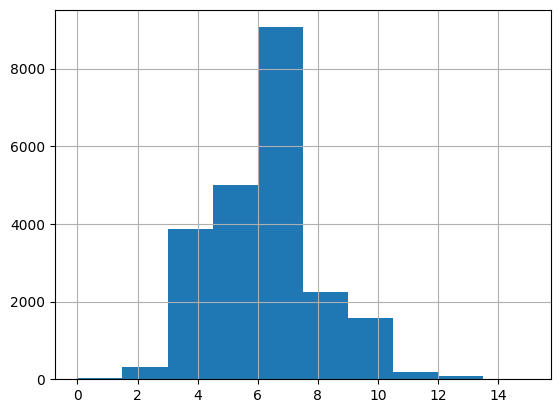

count    22400.000000
mean         5.986205
std          1.784531
min          0.000000
25%          5.000000
50%          6.000000
75%          7.000000
max         15.000000
dtype: float64

In [4]:
import matplotlib.pyplot as plt

rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [5]:
max_len = 15

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

x_train_pad = padding_(x_train,max_len)
x_test_pad = padding_(x_test,max_len)
print(len(x_train_pad), len(y_train))
print(len(x_test_pad), len(y_test))
print(len(x_train_pad[0]))

22400 22400
9600 9600
15


In [6]:
train_tokenized_idx = np.array(x_train_pad)
train_labels_np = np.array(y_train)
train_data = (train_tokenized_idx, train_labels_np)
print(train_tokenized_idx.shape)
print(train_labels_np.shape)

print('now dumping pickle')
with open(file='clickbait-train.pkl', mode='wb') as f:
    pickle.dump(train_data, f)

test_tokenized_idx = np.array(x_test_pad)
test_labels_np = np.array(y_test)
test_data = (test_tokenized_idx, test_labels_np)
print(test_tokenized_idx.shape)
print(test_labels_np.shape)

print('now dumping test pickle')
# with open(file='ag_test.pkl', mode='wb') as f:
with open(file='clickbait-test.pkl', mode='wb') as f:
    pickle.dump(test_data, f)

(22400, 15)
(22400,)
now dumping pickle
(9600, 15)
(9600,)
now dumping test pickle
